In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.ensemble
import sklearn.decomposition
import openml
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import SpectralClustering
from sklearn import metrics
from sklearn import *

import multiprocessing as mp


import itertools as it
from tqdm import tqdm_notebook as tqdm

In [12]:
X, y = getDataset(61)

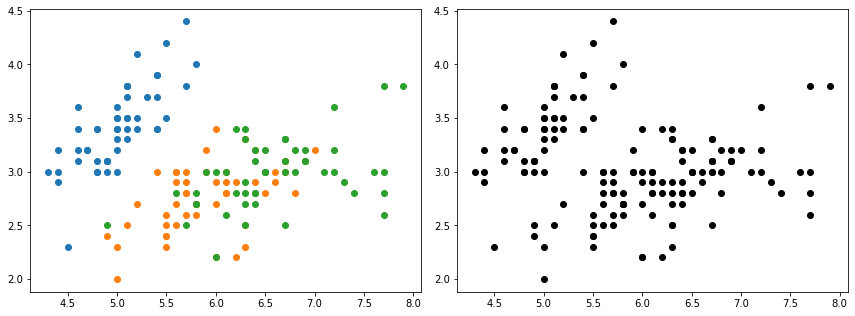

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12,4.5))
for v in np.unique(y):
    Xv = X[y == v]
    ax[0].scatter(Xv[:,0], Xv[:,1])
ax[1].scatter(X[:,0], X[:,1], c="black")
fig.tight_layout()
fig.savefig("/home/felix/Downloads/labeledunlabeled.pdf")

/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



[0.3251428571428571, 0.15333333333333332, 0.10515384615384614, 0.07128, 0.06541666666666666, 0.056521739130434775, 0.05036363636363637, 0.04885714285714285, 0.04510000000000001, 0.04479166666666666, 0.04344444444444443, 0.043058823529411754, 0.037625, 0.04066666666666666, 0.039428571428571424, 0.04153846153846153, 0.03766666666666666, 0.03945454545454545, 0.03860000000000001]


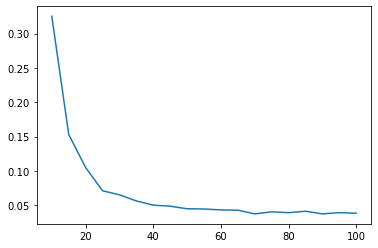

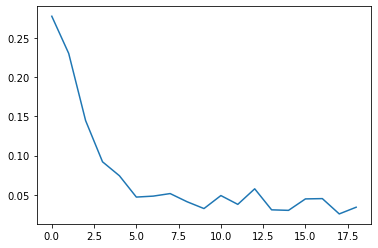

In [99]:
plt.plot(scores)

In [11]:
def fullname(o):
  # o.__module__ + "." + o.__class__.__qualname__ is an example in
  # this context of H.L. Mencken's "neat, plausible, and wrong."
  # Python makes no guarantees as to whether the __module__ special
  # attribute is defined, so we take a more circumspect approach.
  # Alas, the module name is explicitly excluded from __qualname__
  # in Python 3.

    module = o.__module__
    if module is None or module == str.__class__.__module__:
        return o.__name__  # Avoid reporting __builtin__
    else:
        return module + '.' + o.__name__
    
sk.svm.LinearSVC.__module__

'sklearn.svm._classes'

In [4]:
X, y = getDataset(1515)

In [6]:
for trans_class in [None, sk.preprocessing.StandardScaler, sk.preprocessing.Normalizer, sk.preprocessing.PowerTransformer, sk.preprocessing.QuantileTransformer]:
    X_mod = X if trans_class is None else trans_class().fit_transform(X)

    c_knn = sklearn.model_selection.cross_validate(sk.neighbors.KNeighborsClassifier(), X_mod, y)
    c_svc = sklearn.model_selection.cross_validate(sk.svm.LinearSVC(), X_mod, y)
    
    score_knn = 1 - np.mean(c_knn["test_score"])
    score_svc = 1 - np.mean(c_svc["test_score"])
    print(str(trans_class) + ": " + str(score_knn) + " (knn), " + str(score_svc) + " (svc)")

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

None: 0.4132723112128147 (knn), 0.3203356216628528 (svc)
<class 'sklearn.preprocessing._data.StandardScaler'>: 0.4921281464530892 (knn), 0.2556216628527841 (svc)
<class 'sklearn.preprocessing._data.Normalizer'>: 0.3098855835240275 (knn), 0.22765827612509537 (svc)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:3234: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


<class 'sklearn.preprocessing._data.PowerTransformer'>: 0.28898550724637684 (knn), 0.12787185354691089 (svc)


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_data.py:2612: UserWarning: n_quantiles (1000) is greater than the total number of samples (571). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))


<class 'sklearn.preprocessing._data.QuantileTransformer'>: 0.23124332570556816 (knn), 0.1016018306636155 (svc)


In [3]:
def getDataset(openmlid):
    ds = openml.datasets.get_dataset(openmlid)
    df = ds.get_data()[0]
    y = df[ds.default_target_attribute].values
    X = pd.get_dummies(df[[c for c in df.columns if c != ds.default_target_attribute]]).values.astype(float)
    return X, y
#timeout = 60 * 5

def get_class( kls ):
    parts = kls.split('.')
    module = ".".join(parts[:-1])
    m = __import__( module )
    for comp in parts[1:]:
        m = getattr(m, comp)            
    return m


def getLearner(pl):
    
    #pl should be a 5-tuple: (attributes, baseLearner, baseLearnerParams, metaLearner, metaLearnerParams)
    clazz = get_class(pl[1])
    params = {} if pl[2] is None else pl[2]
    return clazz(**params)

In [3]:
def approximateBestPossiblePerformance(learning_curve_dict, target_size, max_possible_slope=-0.01 / 500, estimator=lambda x: np.mean(x)):
    anchor_points = sorted([p for p in learning_curve_dict])
    
    mean_dict = {}
    lowest_score = 1
    lowest_score_anchor = None
    for p in anchor_points:
        s = estimator(learning_curve_dict[p])
        mean_dict[p] = s
        if s < lowest_score:
            lowest_score = s
            lowest_score_anchor = p
    
    # compute maximum slope pairwise
    max_slope_pairwise = -np.inf
    for i, s1 in enumerate(anchor_points):
        y1 = mean_dict[s1]
        for s2 in anchor_points[i+1:]:
            y2 = mean_dict[s2]
            slope = min(max_possible_slope, (y2-y1) / (s2-s1))
            max_slope_pairwise = max(slope, max_slope_pairwise)
            
    # compute slope of last leg
    p1 = anchor_points[-2]
    p2 = anchor_points[-1]
    slope_of_last_leg = (mean_dict[p1] - mean_dict[p2]) / (p1 -p2)
    
    # take the better value
    max_slope = min(max_slope_pairwise, slope_of_last_leg)
    
    # estimate bound
    last_anchor = lowest_score_anchor
    best_possible_improvement = (target_size - last_anchor) * max_slope
    return mean_dict[last_anchor] + best_possible_improvement

def getBestAverageScore(learning_curve):
    best = 1
    for size in learning_curve:
        best = min(best, np.mean(learning_curve[size]))
    return best

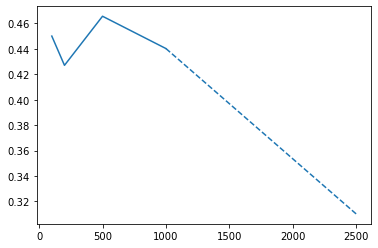

In [4]:
def plotLearningCurve(lc, label = None, ax = None, estimate_target = None):
    A = [x for x in lc]
    B = [np.mean(lc[x]) for x in lc]
    if ax is None:
        fig, ax = plt.subplots()
        
    color = "C" + str(int(len(ax.lines) / 2))
    ax.plot(A, B, color=color, label=label)
    
    if not estimate_target is None:
        target_score = approximateBestPossiblePerformance(lc, estimate_target, estimator=lambda x: np.mean(x))
        last_anchor = max(A)
        ax.plot([last_anchor, estimate_target], [np.mean(lc[last_anchor]), target_score], linestyle="--", color=color)
    
lc = {100: [0.45999999999999996, 0.45999999999999996, 0.45999999999999996, 0.49, 0.3800000000000001], 200: [0.43499999999999994, 0.41500000000000004, 0.42500000000000004, 0.44999999999999996, 0.4099999999999999], 500: [0.492, 0.476, 0.42000000000000004, 0.44399999999999995, 0.496], 1000: [0.45399999999999996, 0.44299999999999995, 0.43499999999999994, 0.43799999999999994, 0.4309999999999998]}
plotLearningCurve(lc, estimate_target = 2500)

In [5]:
class EvaluationPool:
    
    def __init__(self, X, y, anchor_points=[100, 200, 500, 1000, 10000, np.inf], tolerance_tuning = 0.05, tolerance_estimation_error = 0.01):
        self.X = X
        self.y = y
        self.anchor_points = [p for p in anchor_points if p <= len(X) * 0.7]
        if len(self.anchor_points) < len(anchor_points):
            self.anchor_points.append(int(len(X) * 0.7))
        self.bestScore = 1.0
        self.tolerance_tuning = tolerance_tuning
        self.tolerance_estimation_error = tolerance_estimation_error
        self.cache = {}
    
    def tellEvaluation(self, pl, learning_curve):
        spl = str(pl)
        print("Registering " + spl + " in cache of " + str(self))
        self.cache[spl] = (pl, learning_curve)
        
    
    def evaluate(self, pl):
        
        spl = str(pl)
        if spl in self.cache:
            return self.cache[spl][1]
        
        # reduce the data if define
        if not pl[0] is None:
            X_reduced = self.X[:,pl[0]]
        else:
            X_reduced = self.X
        
        # run the learner validation
        learning_curve_dict = {}
        inst = getLearner(pl)
        for size in self.anchor_points:
            #print(str(self) + ": Evaluating " + str(pl) + " on " + str(inst) + " instances in pool ")
            scores_at_size = []
            for seed in range(5):
                X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X_reduced, self.y, train_size=size / len(self.X))
                scores_at_size.append(1 - np.mean(sklearn.model_selection.cross_validate(inst, X_train, y_train)["test_score"]))
                learning_curve_dict[size] = scores_at_size
            
            if size >= 1000:
                estimatedBestPerformance = approximateBestPossiblePerformance(learning_curve_dict, len(self.X), estimator=lambda x: np.quantile(x, 0.25))                
                if estimatedBestPerformance - (self.tolerance_tuning + self.tolerance_estimation_error) > self.bestScore:
                    print("pruning since current performance is " + str(learning_curve_dict) + " and best performance can be " + str(estimatedBestPerformance) + " for training on " + str(len(self.X)) + " datapoints, which is worse than " + str(self.bestScore))
                    self.cache[spl] = (pl, learning_curve_dict)
                    print("Added to cache. Cache size now " + str(len(self.cache)))
                    return learning_curve_dict
            
            score = np.mean(scores_at_size)
            if score < self.bestScore:
                self.bestScore = score
        
        #print(str(self) + ": Evaluations ready.")
        self.cache[spl] = (pl, learning_curve_dict)
        return learning_curve_dict
    
    def getBestCandidates(self, n):
        candidates = sorted([key for key in self.cache], key=lambda k: getBestAverageScore(self.cache[k][1]))
        return [self.cache[c] for c in candidates[:n]]

In [6]:
class NaiveAutoML:
    
    def __init__(self,filtering=False, validation=None):
        self.filtering = filtering
        self.validation = validation
        
        self.chosen_model = None
        self.chosen_attributes = None
        self.num_cpus = mp.cpu_count()
    
    def fit(self, X, y):
        
        self.baseLearners = [
            #("sklearn.svm.LinearSVC", {"max_iter": 1000}),
            ("sklearn.tree.DecisionTreeClassifier", {}),
            #("sklearn.tree.ExtraTreeClassifier", {}),
            #("sklearn.linear_model.LogisticRegression", {}),
            #("sklearn.linear_model.PassiveAggressiveClassifier", {}),
            #("sklearn.linear_model.Perceptron", {}),
            ("sklearn.linear_model.RidgeClassifier", {}),
            ("sklearn.linear_model.SGDClassifier", {}),
            #("sklearn.neural_network.MLPClassifier", {}),
            ("sklearn.discriminant_analysis.LinearDiscriminantAnalysis", {}),
            #("sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis", {}),
            ("sklearn.naive_bayes.BernoulliNB", {}),
            #("sklearn.naive_bayes.MultinomialNB", {}),
            ("sklearn.neighbors.KNeighborsClassifier", {})
        ]
        self.finalizedEnsembles = [
            #("sklearn.ensemble.ExtraTreesClassifier", {}),
            #("sklearn.ensemble.RandomForestClassifier", {"n_estimators": 10}),
            #("sklearn.ensemble.GradientBoostingClassifier", {})
        ]
        
        if self.validation is None:
            X_train, X_valid, y_train, y_valid = (X, None, y, None)
            
        else:
            X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, train_size=1 - self.validation)
            
        print("X_train: " + str(X_train.shape))
        print("X_valid: " + ("-" if X_valid is None else str(X_valid.shape)))
            
        # do probing
        self.pools = []
        #self.pools.append(self.runProbingStage(X, y))
        
        # do filtering
        if self.filtering:
            print("Do Filtering")
            self.pools.append(self.runFilteringStage(X, y))
            
        else:
            print("Skip Filtering")
            
        # select and train final model
        if self.validation is None:
            self.chosen_model = self.pools[-1].getBestCandidates(1)[0][0]
        else:
            self.chosen_model = self.runModelSelectionStage(X_train, y_train, X_valid, y_valid)
        print("Naive AutoML is ready. Building chosen model " + str(self.chosen_model) + " on full dataset.")
        self.chosen_attributes = self.chosen_model[0]
        self.built_model = getLearner(self.chosen_model)
        X_projected = X if self.chosen_attributes is None else X[:,self.chosen_attributes]
        self.built_model.fit(X_projected, y)
    
    def predict(self, X):
        X_projected = X if self.chosen_attributes is None else X[:,self.chosen_attributes]
        return self.built_model.predict(X_projected)
    
    def evaluateCandidateSet(self, candidates, epool):
        tpool = mp.Pool(self.num_cpus)
        learning_curves_handles = []
        for pl in candidates:
            learning_curves_handles.append((pl, tpool.apply_async(epool.evaluate, (pl,))))
        tpool.close()
        tpool.join()
        for pl, lc in learning_curves_handles:
            epool.tellEvaluation(pl, lc.get())
        return epool
    
    def runProbingStage(self, X, y):
        epool = EvaluationPool(X, y)
        self.evaluateCandidateSet([(None, bl[0], bl[1]) for bl in self.baseLearners + self.finalizedEnsembles], epool)
        return epool
    
    def runModelSelectionStage(self, X_train, y_train, X_valid, y_valid):
        candidates = self.pools[-1].getBestCandidates(10)
        best_score = 1
        output = None
        for pl, lc in candidates:
            attribute_set = range(X_train.shape[1]) if pl[0] is None else pl[0]
            learner = getLearner(pl)
            learner.fit(X_train[:,attribute_set], y_train)
            y_hat = learner.predict(X_valid[:,attribute_set])
            score = 1 - sklearn.metrics.accuracy_score(y_valid, y_hat)
            print("Validation score of " + str(pl) + " is " + str(score))
            if score < best_score:
                best_score = score
                output = pl
        return output
    
    def runFilteringStage(self, X, y):
        tpool = mp.Pool(self.num_cpus)
        X_red = X[:1000]
        y_red = y[:1000]
        results = []
        for f in [
                sklearn.feature_selection.f_classif,
                sklearn.feature_selection.mutual_info_classif,
                sklearn.feature_selection.chi2
            ]:
            results.append(tpool.apply_async(self.runFilter, (X_red, y_red, f)))
        tpool.close()
        tpool.join()
        print("Filterings completed. Identifying best feature pilot set.")
        best_score = 1
        best_att_selection = None
        for r in results:
            attributes, n, score = r.get()
            if score < best_score:
                best_score = score
                best_att_selection = attributes
        
        print("Now evaluating all candidates on reduced set: " + str(best_att_selection))
        epool = EvaluationPool(X, y)
        self.evaluateCandidateSet([(best_att_selection, bl[0], bl[1]) for bl in self.baseLearners + self.finalizedEnsembles], epool)
        return epool
            
    def runFilter(self, X, y, f):
        try:
            gus = sklearn.feature_selection.GenericUnivariateSelect(score_func=f)
            gus.fit(X, y)
            args = list(np.argsort(gus.scores_))
            args.reverse()
            epool = EvaluationPool(X, y)

            best_combo = None
            best_n = 0
            best_score = 1
            iterations_without_improvement = 0

            for n in range(1, len(args) + 1):
                score = getBestAverageScore(epool.evaluate((args[:n], "sklearn.neighbors.KNeighborsClassifier", {})))
                print(score)
                if score < best_score:
                    best_score = score
                    best_n = n
                    best_combo = args[:n]
                    iterations_without_improvement = 0
                else:
                    iterations_without_improvement += 1
                    if iterations_without_improvement > 10:
                        print("no improvement in 10 iterations. Stopping")
                        return (best_combo, best_n, best_score)
        except:
            print("ERRRROROORRR")
            raise Exception()
            
            
            #self.evaluateCandidateSet(self.baseLearners + self.finalizedEnsembles, epool)
            
    
    def getPools(self):
        return self.pools    

In [ ]:
X, y = getDataset(1485)
scores = []
for seed in range(10):
    X_train, X_valid, y_train, y_valid = sklearn.model_selection.train_test_split(X, y, train_size=0.9, random_state = seed)
    naml = NaiveAutoML(filtering=True, validation=0.1)
    naml.fit(X_train, y_train)
    print("Chosen model: " + str(naml.chosen_model))
    y_hat = naml.predict(X_valid)
    score = 1 - sklearn.metrics.accuracy_score(y_valid, y_hat)
    print("Test score:", score)
    scores.append(score)

X_train: (2106, 500)
X_valid: (234, 500)
Do Filtering
0.4425714285714285
0.41
0.394
0.38899999999999996
0.32
0.388
0.322
0.43200000000000005
0.31314285714285717
0.32199999999999995
0.27314285714285713
0.45499999999999996
0.316
0.41400000000000003
0.23685714285714293
0.26159999999999994
0.41600000000000004
0.23485714285714288
0.2177142857142857
0.42400000000000004
0.20857142857142855
0.21028571428571433
0.40685714285714286
0.22371428571428575
0.18142857142857144
0.42000000000000004
0.18400000000000002
0.1905714285714286
0.41999999999999993
0.17857142857142855
0.18228571428571433
0.41600000000000004
0.18714285714285708
0.17571428571428568
0.40199999999999997
0.1734285714285714
0.17685714285714285
0.42028571428571426
0.18742857142857142
0.18628571428571425
0.36
0.19057142857142856
0.18628571428571433
0.176
0.3685714285714286
0.18571428571428575
0.17971428571428574
0.35300000000000004
0.19371428571428576
0.18057142857142855
0.36200000000000004
0.18714285714285717
0.1777142857142858
0.362
0

([475, 336, 105, 493, 453, 64, 241, 442, 338, 378, 48, 153, 472], 'sklearn.neighbors.KNeighborsClassifier', {}): 0.12832251808756615
([475, 336, 105, 493, 453, 64, 241, 442, 338, 378, 48, 153, 472], 'sklearn.tree.DecisionTreeClassifier', {}): 0.2180663086447378
([475, 336, 105, 493, 453, 64, 241, 442, 338, 378, 48, 153, 472], 'sklearn.linear_model.RidgeClassifier', {}): 0.3888
([475, 336, 105, 493, 453, 64, 241, 442, 338, 378, 48, 153, 472], 'sklearn.discriminant_analysis.LinearDiscriminantAnalysis', {}): 0.3888
([475, 336, 105, 493, 453, 64, 241, 442, 338, 378, 48, 153, 472], 'sklearn.naive_bayes.BernoulliNB', {}): 0.4539999999999999


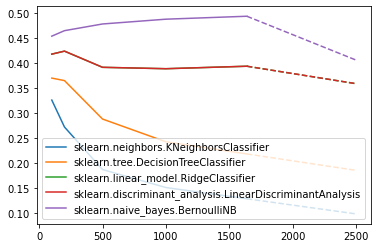

In [8]:
fig, ax = plt.subplots()
for pl, lc in naml.getPools()[0].getBestCandidates(5):
    print(str(pl) + ": " + str(getBestAverageScore(lc)))
    plotLearningCurve(lc, label=pl[1], ax = ax, estimate_target = 2500)
ax.legend()

In [285]:
gus = sklearn.feature_selection.GenericUnivariateSelect(score_func=sklearn.feature_selection.f_classif)
gus.fit(X, y)
args = list(np.argsort(gus.scores_))
args.reverse()

for i in range(1, 20):
    pl = (args[:i], "sklearn.ensemble.RandomForestClassifier", {"n_estimators": 10})
    print(pl)
    pool.evaluate(pl)
    #print([gus.scores_[i] for i in args])

([475], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64, 338], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64, 338, 128], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64, 338, 128, 105], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64, 338, 128, 105, 442], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64, 338, 128, 105, 442, 472], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
([475, 241, 336, 64, 338, 128, 105, 442, 472, 48], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
1000 {100: [0.39, 0.44000000000000006, 0.389999999999

1819 {100: [0.37, 0.3400000000000001, 0.30000000000000004, 0.43000000000000005, 0.38], 200: [0.3500000000000001, 0.33999999999999997, 0.345, 0.395, 0.3700000000000001], 500: [0.30000000000000004, 0.268, 0.2859999999999999, 0.3440000000000001, 0.2619999999999999], 1000: [0.2260000000000001, 0.22199999999999986, 0.244, 0.2350000000000001, 0.23199999999999998], 1819: [0.19735264735264724, 0.19516089970635409, 0.1858081312626767, 0.177006327006327, 0.18856295219931574]}
([475, 241, 336, 64, 338, 128, 105, 442, 472, 48, 378, 493, 453, 323, 424, 496, 55, 285], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10})
1000 {100: [0.3699999999999999, 0.44999999999999996, 0.3699999999999999, 0.26, 0.30000000000000004], 200: [0.385, 0.375, 0.30999999999999994, 0.375, 0.32499999999999996], 500: [0.28600000000000003, 0.30599999999999994, 0.28800000000000003, 0.30999999999999994, 0.28800000000000003], 1000: [0.25, 0.268, 0.238, 0.22299999999999998, 0.22499999999999998]}
1819 {100: [0.3699999

([475, 241, 336, 64, 338, 128, 105, 442, 472, 48, 378, 493], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10}): 0.17228922592558954
1819 {100: [0.37, 0.30000000000000004, 0.42000000000000004, 0.35, 0.3899999999999999], 200: [0.21999999999999997, 0.30499999999999994, 0.4, 0.30500000000000005, 0.275], 500: [0.2380000000000001, 0.31000000000000016, 0.2620000000000001, 0.274, 0.22999999999999998], 1000: [0.20799999999999996, 0.19800000000000006, 0.20599999999999996, 0.19999999999999996, 0.17699999999999994], 1819: [0.17317228226319126, 0.1737141646232555, 0.17648412193866747, 0.1687645687645688, 0.1693109920382646]}
([475, 241, 336, 64, 338, 128, 105, 442, 472, 48, 378, 493, 453], 'sklearn.ensemble.RandomForestClassifier', {'n_estimators': 10}): 0.1729422093058457
1819 {100: [0.33000000000000007, 0.42999999999999994, 0.3600000000000001, 0.35, 0.28], 200: [0.31499999999999995, 0.30999999999999994, 0.3799999999999999, 0.35, 0.31500000000000006], 500: [0.256, 0.2580000000000001

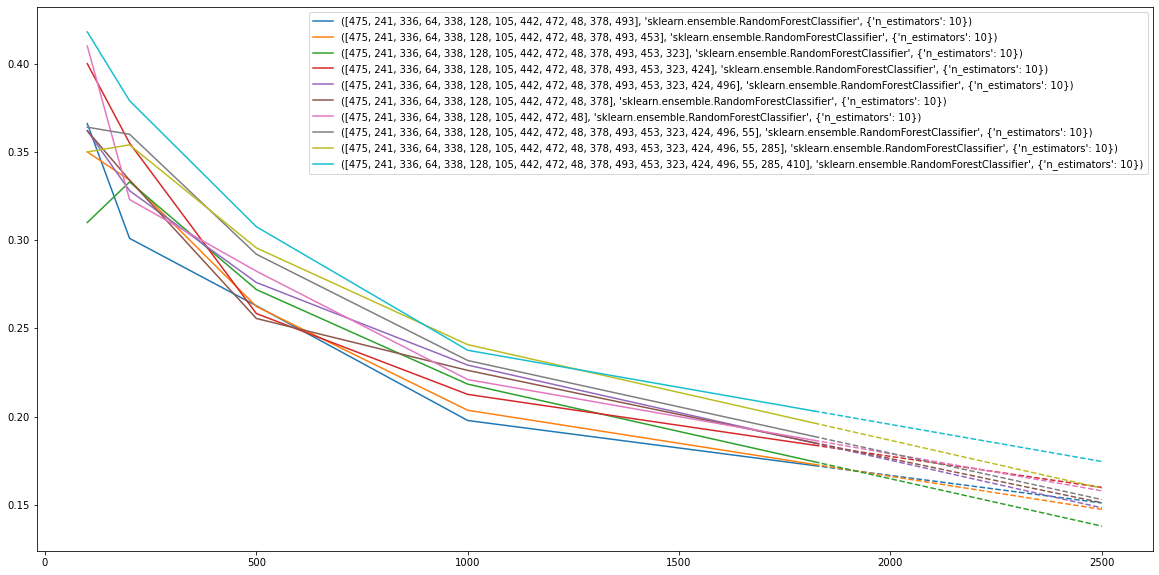

In [286]:
fig, ax = plt.subplots(figsize=(20, 10))
for pl, lc in pool.getBestPipelines(10):
    print(str(pl) + ": " + str(getBestAverageScore(lc)))
    plotLearningCurve(lc, label=pl, ax = ax, estimate_target = 2500)
ax.legend()

In [61]:
#def naiveautoml(X, y):
    


constructors = {
    #svm.LinearSVC: [svm.LinearSVC(C=10**i,dual=d) for d in [True, False] for i in [-3, -2, -1, 0, 1, 2, 3]]
}





    

def naiveautoml(X, y):
    
    
    print("Separated data into " + str(len(X_train)) + " train instances and " + str(len(X_valid)) + " validation instances.")
    
    bestModel = None
    bestScore = 1

    # get best base learners
    

    #for bl in tqdm(baseLearners):
    #    for metaLearner in [ensemble.AdaBoostClassifier]:
    #        inst = bl()
    #        ml = metaLearner(base_estimator=inst, algorithm="SAMME")
    #        try:
    #            cv = sklearn.model_selection.cross_validate(ml, X, y)
    #            score = 1 - np.mean(cv["test_score"])
    #            if score < bestScore:
    #                bestModel = inst
    #                bestScore = score
    #                print("New best model " + metaLearner.__name__ + " + " + bl.__name__ + " with score " + str(score))
    #            print(metaLearner.__name__, score)
    #        except:
    #            print ("There was a problem")
    return bestModel

def evalNaiveAutoML(openmlid):
    X, y = getDataset(openmlid)
    scores = []
    for seed in range(10):
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.9, random_state=seed)
        model = naiveautoml(X_train, y_train)
        print("obtained model, now validating.")
        model.fit(X_train, y_train)
        y_hat = model.predict(X_test)
        scores.append(1 - sklearn.metrics.accuracy_score(y_test, y_hat))
        print("Ready. new score is " + str(scores))
    print(openmlid, np.mean(scores))
    
                
datasets_suite_271 = [
    1590, 1515, 1457, 1475, 1468, 1486, 1489, 23512, 23517, 4541, 4534, 4538, 4134, 
    4135, 40978, 40996, 41027, 40981, 40982, 40983, 40984, 40701, 40670, 40685, 40900, 
    1111, 42732, 42733, 42734, 40498, 41161, 41162, 41163, 41164, 41165, 41166, 41167, 
    41168, 41169, 41142, 41143, 41144, 41145, 41146, 41147, 41150, 41156, 41157, 41158, 
    41159, 41138, 54, 181, 188, 1461, 1494, 1464, 12, 23, 3, 1487, 40668, 1067, 1049, 
    40975, 31 
]

In [62]:
evalNaiveAutoML(1515)

DEBUG:openml.datasets.dataset:Data pickle file already exists and is up to date.


Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.25806451612903225 0.21153846153846156 0.2348014888337469
New best model LinearSVC with score 0.2348014888337469
DecisionTreeClassifier 0.25165965404394575 0.28846153846153844 0.2700605962527421
ExtraTreeClassifier 0.46201496026180455 0.4423076923076923 0.4521613262847484


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.17566619915848525 0.11538461538461542 0.14552540727155033
New best model LogisticRegression with score 0.14552540727155033
PassiveAggressiveClassifier 0.22781673679289383 0.21153846153846156 0.2196775991656777
Perceptron 0.2320944366526414 0.1923076923076923 0.21220106448016685
RidgeClassifier 0.5987844787283778 0.5576923076923077 0.5782383932103428


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.64266e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.29605e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.24276e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.55367e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.80613e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/pyth

RidgeClassifierCV 0.5987844787283778 0.5576923076923077 0.5782383932103428
SGDClassifier 0.22127162225338937 0.23076923076923073 0.22602042651131005
MLPClassifier 0.2515895278167368 0.1923076923076923 0.22194861006221456
LinearDiscriminantAnalysis 0.42947639083683975 0.3846153846153846 0.40704588772611217
QuadraticDiscriminantAnalysis 0.9501402524544179 0.9807692307692307 0.9654547416118243


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.1453716690042075 0.15384615384615385 0.14960891142518068
GaussianNB 0.1627162225338944 0.17307692307692313 0.16789657280540876
MultinomialNB 0.13445535296867706 0.15384615384615385 0.14415075340741546
New best model MultinomialNB with score 0.14415075340741546
KNeighborsClassifier 0.3817671809256662 0.34615384615384615 0.36396051353975617
ExtraTreesClassifier 0.12370266479663383 0.15384615384615385 0.13877440932139384
New best model ExtraTreesClassifier with score 0.13877440932139384
RandomForestClassifier 0.11283309957924259 0.11538461538461542 0.114108857481929
New best model RandomForestClassifier with score 0.114108857481929

obtained model, now validating.
Ready. new score is [0.15517241379310343]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.28648901355773737 0.23076923076923073 0.25862912216348405
New best model LinearSVC with score 0.25862912216348405
DecisionTreeClassifier 0.25163627863487614 0.3076923076923077 0.2796642931635919
ExtraTreeClassifier 0.41879382889200567 0.46153846153846156 0.4401661452152336


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.17795698924731185 0.11538461538461542 0.14667080231596363
New best model LogisticRegression with score 0.14667080231596363
PassiveAggressiveClassifier 0.24518466573165032 0.1923076923076923 0.2187461790196713
Perceptron 0.2537868162692847 0.23076923076923073 0.2422780235192577
RidgeClassifier 0.6532258064516129 0.7115384615384616 0.6823821339950372


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.25173e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.40139e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.23925e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.33367e-18): result may not be accurate.
 

RidgeClassifierCV 0.6532258064516129 0.7115384615384616 0.6823821339950372
SGDClassifier 0.2385460495558671 0.25 0.24427302477793356
MLPClassifier 0.24294062646096304 0.3076923076923077 0.2753164670766354
LinearDiscriminantAnalysis 0.4598176718092567 0.3846153846153846 0.42221652821232064


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

QuadraticDiscriminantAnalysis 0.9609864422627395 0.9615384615384616 0.9612624519006006
BernoulliNB 0.14317438055165965 0.11538461538461542 0.12927949796813754
New best model BernoulliNB with score 0.12927949796813754
GaussianNB 0.20397381954184202 0.13461538461538458 0.1692946020786133
MultinomialNB 0.13017765310892937 0.17307692307692313 0.15162728809292625
KNeighborsClassifier 0.40130902290790094 0.42307692307692313 0.41219297299241203
ExtraTreesClassifier 0.15179990649836372 0.17307692307692313 0.16243841478764343
RandomForestClassifier 0.13232819074333801 0.13461538461538458 0.1334717876793613

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.2819775596072931 0.23076923076923073 0.2563733951882619
New best model LinearSVC with score 0.2563733951882619
DecisionTreeClassifier 0.2451379149135109 0.34615384615384615 0.2956458805336785
ExtraTreeClassifier 0.4554932211313698 0.46153846153846156 0.4585158413349157


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.1952547919588593 0.17307692307692313 0.18416585751789122
New best model LogisticRegression with score 0.18416585751789122
PassiveAggressiveClassifier 0.24939223936418886 0.21153846153846156 0.2304653504513252
Perceptron 0.21470313230481541 0.28846153846153844 0.2515823353831769
RidgeClassifier 0.6266012155212717 0.6923076923076923 0.659454453914482


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.96004e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.74448e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.4037e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.70051e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dua

RidgeClassifierCV 0.6266012155212717 0.6923076923076923 0.659454453914482
SGDClassifier 0.21044880785413744 0.32692307692307687 0.26868594238860716
MLPClassifier 0.23651238896680693 0.23076923076923073 0.23364080986801883
LinearDiscriminantAnalysis 0.41856007480130897 0.40384615384615385 0.4112031143237314
QuadraticDiscriminantAnalysis 0.9370500233754091 0.8846153846153846 0.9108327039953968


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.16266947171575497 0.21153846153846156 0.18710396662710826
GaussianNB 0.17774661056568486 0.1923076923076923 0.18502715143668858
MultinomialNB 0.128003740065451 0.13461538461538458 0.1313095623404178
New best model MultinomialNB with score 0.1313095623404178
KNeighborsClassifier 0.37318840579710144 0.3846153846153846 0.378901895206243
ExtraTreesClassifier 0.14747545582047683 0.13461538461538458 0.1410454202179307
RandomForestClassifier 0.13223468910705927 0.21153846153846156 0.17188657532276042

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.2536699392239363 0.2692307692307693 0.2614503542273528
New best model LinearSVC with score 0.2614503542273528
DecisionTreeClassifier 0.2364656381486676 0.28846153846153844 0.262463588305103
ExtraTreeClassifier 0.5074333800841515 0.5192307692307692 0.5133320746574603


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.16486676016830304 0.21153846153846156 0.1882026108533823
New best model LogisticRegression with score 0.1882026108533823
PassiveAggressiveClassifier 0.21678354371201503 0.25 0.2333917718560075
Perceptron 0.20161290322580638 0.25 0.2258064516129032
RidgeClassifier 0.6071996259934549 0.7307692307692308 0.6689844283813429


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.38911e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.93375e-19): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.51828e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.59512e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.32477e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/pyth

RidgeClassifierCV 0.6071996259934549 0.7307692307692308 0.6689844283813429
SGDClassifier 0.20381019167835435 0.3076923076923077 0.25575124968533103
MLPClassifier 0.21912108461898083 0.23076923076923073 0.22494515769410578
LinearDiscriminantAnalysis 0.399111734455353 0.5384615384615384 0.4687866364584457
QuadraticDiscriminantAnalysis 0.9414679756895745 0.9615384615384616 0.951503218614018


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.1366526414212249 0.1923076923076923 0.1644801668644586
New best model BernoulliNB with score 0.1644801668644586
GaussianNB 0.17573632538569428 0.15384615384615385 0.16479123961592407
MultinomialNB 0.12148200093501649 0.17307692307692313 0.1472794620059698
New best model MultinomialNB with score 0.1472794620059698
KNeighborsClassifier 0.377466105656849 0.42307692307692313 0.40027151436688607
ExtraTreesClassifier 0.1366526414212249 0.1923076923076923 0.1644801668644586
RandomForestClassifier 0.12367928938756434 0.17307692307692313 0.14837810623224373

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.23854604955586733 0.17307692307692313 0.20581148631639523
New best model LinearSVC with score 0.20581148631639523
DecisionTreeClassifier 0.23419822346891062 0.25 0.2420991117344553
ExtraTreeClassifier 0.44022907900888275 0.42307692307692313 0.43165300104290294
LogisticRegression 0.1865591397849462 0.05769230769230771 0.12212572373862696
New best model LogisticRegression with score 0.12212572373862696
PassiveAggressiveClassifier 0.24069658719027587 0.17307692307692313 0.2068867551335995
Perceptron 0.2625759700794763 0.17307692307692313 0.21782644657819972
RidgeClassifier 0.5033193080878915 0.5576923076923077 0.5305058078900996


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.18172e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=2.65344e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.30847e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.04738e-18): result may not be accurate.
 

RidgeClassifierCV 0.5033193080878915 0.5576923076923077 0.5305058078900996
SGDClassifier 0.22999064983637219 0.21153846153846156 0.22076455568741687
MLPClassifier 0.21690042075736327 0.1923076923076923 0.20460405653252778
LinearDiscriminantAnalysis 0.4034829359513792 0.4423076923076923 0.42289531412953574
QuadraticDiscriminantAnalysis 0.9414913510986442 0.9807692307692307 0.9611302909339374


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.14964936886395497 0.1923076923076923 0.17097853058582363
GaussianNB 0.1865591397849462 0.21153846153846156 0.19904880066170388
MultinomialNB 0.11928471248246841 0.13461538461538458 0.1269500485489265
KNeighborsClassifier 0.3666432912575971 0.3653846153846154 0.36601395332110626
ExtraTreesClassifier 0.13010752688172045 0.15384615384615385 0.14197684036393715
RandomForestClassifier 0.1453716690042075 0.15384615384615385 0.14960891142518068

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934, 0.12068965517241381]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.23426834969611954 0.23076923076923073 0.23251879023267513
New best model LinearSVC with score 0.23251879023267513
DecisionTreeClassifier 0.2712248714352501 0.25 0.26061243571762505
ExtraTreeClassifier 0.4642122487143525 0.46153846153846156 0.46287535512640704
LogisticRegression 0.20605423094904152 0.21153846153846156 0.20879634624375154
New best model LogisticRegression with score 0.20879634624375154
PassiveAggressiveClassifier 0.2039504441327724 0.13461538461538458 0.1692829143740785
New best model PassiveAggressiveClassifier with score 0.1692829143740785
Perceptron 0.22765310892940627 0.23076923076923073 0.2292111698493185
RidgeClassifier 0.3904862085086489 0.4423076923076923 0.4163969504081706


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=8.78053e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=7.56916e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.0752e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.88098e-17): result may not be accurate.
  

RidgeClassifierCV 0.3904862085086489 0.4423076923076923 0.4163969504081706
SGDClassifier 0.2320944366526414 0.23076923076923073 0.23143183371093606
MLPClassifier 0.24064983637213655 0.25 0.24532491818606827
LinearDiscriminantAnalysis 0.4188405797101449 0.3846153846153846 0.40172798216276473
QuadraticDiscriminantAnalysis 0.9457456755493221 1.0 0.972872837774661


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.1670640486208509 0.1923076923076923 0.1796858704642716
GaussianNB 0.18875642823749406 0.17307692307692313 0.1809166756572086
MultinomialNB 0.13237494156147722 0.05769230769230771 0.09503362462689247
New best model MultinomialNB with score 0.09503362462689247
KNeighborsClassifier 0.40341280972417015 0.32692307692307687 0.3651679433236235
ExtraTreesClassifier 0.13237494156147744 0.05769230769230771 0.09503362462689258
RandomForestClassifier 0.13454885460495558 0.09615384615384615 0.11535135037940086

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934, 0.12068965517241381, 0.06896551724137934]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.2863020102851801 0.21153846153846156 0.24892023591182083
New best model LinearSVC with score 0.24892023591182083
DecisionTreeClassifier 0.21255259467040677 0.32692307692307687 0.2697378357967418
ExtraTreeClassifier 0.4771856007480131 0.5576923076923077 0.5174389542201604


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.16280972417017292 0.1923076923076923 0.1775587082389326
New best model LogisticRegression with score 0.1775587082389326
PassiveAggressiveClassifier 0.2711781206171108 0.1923076923076923 0.23174290646240153
Perceptron 0.25829827021972884 0.25 0.2541491351098644
RidgeClassifier 0.6203132304815334 0.6730769230769231 0.6466950767792283


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.0545e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.57442e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.49336e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.09274e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dua

RidgeClassifierCV 0.6203132304815334 0.6730769230769231 0.6466950767792283
SGDClassifier 0.22784011220196354 0.21153846153846156 0.21968928687021255
MLPClassifier 0.2538803179055632 0.21153846153846156 0.23270938972201238
LinearDiscriminantAnalysis 0.3751753155680225 0.4807692307692307 0.4279722731686266
QuadraticDiscriminantAnalysis 0.9652641421224871 0.9615384615384616 0.9634013018304743


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.12150537634408598 0.13461538461538458 0.12806038047973528
New best model BernoulliNB with score 0.12806038047973528
GaussianNB 0.15846189808321642 0.21153846153846156 0.185000179810839
MultinomialNB 0.11940158952781665 0.11538461538461542 0.11739310245621604
New best model MultinomialNB with score 0.11739310245621604
KNeighborsClassifier 0.39268349696119675 0.2692307692307693 0.330957133095983
ExtraTreesClassifier 0.11061243571762502 0.11538461538461542 0.11299852555112022
New best model ExtraTreesClassifier with score 0.11299852555112022
RandomForestClassifier 0.10841514726507706 0.11538461538461542 0.11189988132484624
New best model RandomForestClassifier with score 0.11189988132484624

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934, 0.12068965517241381, 0.06896551724137934, 0.18965517241379315]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.29083683964469365 0.1923076923076923 0.24157226597619297
New best model LinearSVC with score 0.24157226597619297
DecisionTreeClassifier 0.2712014960261804 0.11538461538461542 0.1932930557053979
New best model DecisionTreeClassifier with score 0.1932930557053979
ExtraTreeClassifier 0.4533894343151006 0.32692307692307687 0.39015625561908873


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.2039270687237027 0.17307692307692313 0.1885019959003129
New best model LogisticRegression with score 0.1885019959003129
PassiveAggressiveClassifier 0.26259934548854613 0.15384615384615385 0.20822274966735
Perceptron 0.24090696587190275 0.28846153846153844 0.2646842521667206
RidgeClassifier 0.6007713884992988 0.5384615384615384 0.5696164634804186


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.86244e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.34202e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.21006e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:190: UserWarning: Singular matrix in solving dual problem. Using least-squares solution inste

RidgeClassifierCV 0.6007713884992988 0.5384615384615384 0.5696164634804186
SGDClassifier 0.23225806451612896 0.1923076923076923 0.21228287841191062
MLPClassifier 0.24960261804581574 0.17307692307692313 0.21133977056136943
LinearDiscriminantAnalysis 0.42082748948106585 0.42307692307692313 0.4219522062789945
QuadraticDiscriminantAnalysis 0.958765778401122 0.9615384615384616 0.9601521199697918


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.15409069658719032 0.13461538461538458 0.14435304060128745
New best model BernoulliNB with score 0.14435304060128745
GaussianNB 0.21484338475923326 0.09615384615384615 0.1554986154565397
MultinomialNB 0.13447872837774655 0.05769230769230771 0.09608551803502713
New best model MultinomialNB with score 0.09608551803502713
KNeighborsClassifier 0.39062646096306675 0.3076923076923077 0.34915938432768723
ExtraTreesClassifier 0.14976624590930354 0.09615384615384615 0.12296004603157484
RandomForestClassifier 0.15409069658719032 0.09615384615384615 0.12512227137051823

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934, 0.12068965517241381, 0.06896551724137934, 0.18965517241379315, 0.06896551724137934]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.29062646096306677 0.2692307692307693 0.279928615096918
New best model LinearSVC with score 0.279928615096918
DecisionTreeClassifier 0.24502103786816265 0.23076923076923073 0.2378951343186967
New best model DecisionTreeClassifier with score 0.2378951343186967
ExtraTreeClassifier 0.44686769518466574 0.40384615384615385 0.4253569245154098


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.18870967741935485 0.15384615384615385 0.17127791563275435
New best model LogisticRegression with score 0.17127791563275435
PassiveAggressiveClassifier 0.2559373539036933 0.17307692307692313 0.21450713849030822
Perceptron 0.24294062646096304 0.25 0.24647031323048152
RidgeClassifier 0.6333099579242636 0.6923076923076923 0.6628088251159779


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.72359e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.1573e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=6.39266e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.58321e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.21721e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/pytho

RidgeClassifierCV 0.6333099579242636 0.6923076923076923 0.6628088251159779
SGDClassifier 0.23426834969611965 0.25 0.24213417484805982
MLPClassifier 0.2385226741467975 0.23076923076923073 0.23464595245801412
LinearDiscriminantAnalysis 0.3968910705937354 0.5192307692307692 0.4580609199122523
QuadraticDiscriminantAnalysis 0.9609396914446002 0.9615384615384616 0.9612390764915308


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

BernoulliNB 0.16030855539971944 0.15384615384615385 0.15707735462293665
New best model BernoulliNB with score 0.15707735462293665
GaussianNB 0.18211781206171107 0.1923076923076923 0.18721275218470168
MultinomialNB 0.11493688639551203 0.09615384615384615 0.10554536627467909
New best model MultinomialNB with score 0.10554536627467909
KNeighborsClassifier 0.42723235156615247 0.40384615384615385 0.41553925270615316
ExtraTreesClassifier 0.14525479195885926 0.09615384615384615 0.1207043190563527
RandomForestClassifier 0.12358578775128559 0.13461538461538458 0.1291005861833351

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934, 0.12068965517241381, 0.06896551724137934, 0.18965517241379315, 0.06896551724137934, 0.15517241379310343]
Separated data into 461 train instances and 52 validation instances.


/home/felix/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

LinearSVC 0.27755960729312756 0.28846153846153844 0.283010572877333
New best model LinearSVC with score 0.283010572877333
DecisionTreeClassifier 0.2689340813464236 0.2692307692307693 0.26908242528859644
New best model DecisionTreeClassifier with score 0.26908242528859644
ExtraTreeClassifier 0.4619214586255259 0.40384615384615385 0.4328838062358399


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

LogisticRegression 0.19079008882655446 0.05769230769230771 0.12424119825943108
New best model LogisticRegression with score 0.12424119825943108
PassiveAggressiveClassifier 0.24936886395511926 0.25 0.24968443197755963
Perceptron 0.23627863487611034 0.1923076923076923 0.21429316359190131
RidgeClassifier 0.5791725105189341 0.6153846153846154 0.5972785629517747


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=4.41087e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=9.54159e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.34059e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=1.02813e-17): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=5.36903e-18): result may not be accurate.
  overwrite_a=False)
/home/felix/anaconda3/lib/pyth

RidgeClassifierCV 0.5791725105189341 0.6153846153846154 0.5972785629517747
SGDClassifier 0.22760635811126695 0.17307692307692313 0.20034164059409504
MLPClassifier 0.255890603085554 0.13461538461538458 0.1952529938504693
LinearDiscriminantAnalysis 0.3969378214118747 0.42307692307692313 0.4100073722443989


/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:808: UserWarning: Variables are collinear
  warnings.warn("Variables are coll

QuadraticDiscriminantAnalysis 0.9306217858812529 0.9038461538461539 0.9172339698637033
BernoulliNB 0.14752220663861615 0.17307692307692313 0.16029956485776964
GaussianNB 0.20607760635811123 0.23076923076923073 0.21842341856367098
MultinomialNB 0.12148200093501627 0.05769230769230771 0.08958715431366199
New best model MultinomialNB with score 0.08958715431366199
KNeighborsClassifier 0.388218793828892 0.25 0.319109396914446
ExtraTreesClassifier 0.13017765310892937 0.13461538461538458 0.13239651886215698
RandomForestClassifier 0.12143525011687717 0.11538461538461542 0.1184099327507463

obtained model, now validating.
Ready. new score is [0.15517241379310343, 0.2586206896551724, 0.08620689655172409, 0.06896551724137934, 0.12068965517241381, 0.06896551724137934, 0.18965517241379315, 0.06896551724137934, 0.15517241379310343, 0.12068965517241381]
1515 0.12931034482758622


In [35]:
trans = sklearn.preprocessing.QuantileTransformer(n_quantiles=431,output_distribution="normal")

In [41]:
X, y = getDataset(1515)

In [42]:
XP = trans.fit_transform(X)

In [50]:
inst = sklearn.svm.LinearSVC()
#XP = sklearn.feature_selection.SelectPercentile(percentile=80,score_func=sklearn.feature_selection.chi2).fit_transform(X, y)
#XP = trans.fit_transform(XP)
sklearn.model_selection.cross_validate(inst, X, y)["test_score"]

/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/felix/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of ite

array([0.59130435, 0.66666667, 0.71052632, 0.73684211, 0.69298246])